In [1]:
%matplotlib inline

In [2]:
%run ./setup_notebook.ipynb

In [3]:
# notebook specific imports
import pickle
import copy
import utils.utils_funcs as utils
import math
from subsets_analysis import Subsets
from scipy import signal
from sklearn.preprocessing import minmax_scale
import random

In [4]:
run_dict = {
            'J048' : [27, 29, 30, 32], 
            'RL048': [23, 24, 25, 28, 29]
           }

In [5]:
pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/'

runs = []
for mouse in run_dict:
    for run_number in run_dict[mouse]:
        run_path = os.path.join(pkl_path, mouse, 'run{}.pkl'.format(run_number))
        with open(run_path, 'rb') as f:
            r = pickle.load(f)
            runs.append(r)

In [6]:
# how many frames before and after the onset of lick trial to include in the kernal
pre_frames  = 5
post_frames = 9
fs = 5  # frame rate / plane

# empirally observed that 1.4 seconds after onset the artifact has gone for 150 cell trials
# offset = math.ceil(1.4*fs)

# empirally observed that offset = 4 for non-150 cell stims
offset = 4

n_sessions = len(runs)
np.mean = np.nanmean  # lots of nans to deal with here

offset

4

In [7]:
def select_s2(run):

    s2_cells = []
    for i,s in enumerate(run.stat):
        if s['med'][1] > 512:
            s2_cells.append(i)
        
    run.flu = run.flu[s2_cells,:]
    run.frames_ms = run.frames_ms[s2_cells,:]
    run.frames_ms_pre = run.frames_ms_pre[s2_cells,:]
    run.stat = run.stat[s2_cells]
    
    return run

In [8]:
def build_flu_array(run, stim_times, pre_frames=10, post_frames=50, 
                    is_prereward=False):
    
    flu = run.flu
    
    if is_prereward:
        frames_ms = run.frames_ms_pre
    else:
        frames_ms = run.frames_ms
        
#     # split flu matrix into trials based on stim time
    flu_array = utils.flu_splitter3(flu, stim_times, frames_ms,
                                    pre_frames=pre_frames, post_frames=post_frames)
    
    return flu_array

In [9]:
def averager(array_list, pre_frames=10, post_frames=50, offset=0, trial_filter=None,
             plot=False, fs=5):

    if trial_filter:
        assert len(trial_filter) == len(array_list)
        array_list = [arr[:,filt,:] for arr, filt in zip(array_list, trial_filter)]
    
    cell_average = [np.mean(k, 1) for k in array_list] 
    session_average = np.array([np.mean(np.mean(k, 0), 0) for k in array_list])  

    scaled_average = np.array([session_average[i,:] - session_average[i,0] 
                               for i in range(n_sessions)])
    
    grand_average = np.mean(scaled_average, 0)
       
    if plot:        
#         x_axis = (np.arange(-pre_frames, post_frames) + 1)  / fs
        x_axis = range(len(grand_average))
        plt.plot(x_axis, grand_average)
        plt.plot(x_axis[0:pre_frames], grand_average[0:pre_frames], color='red')
        plt.plot(x_axis[pre_frames+offset:pre_frames+offset+(post_frames-offset)],
                 grand_average[pre_frames+offset:pre_frames+offset+(post_frames-offset)], color='red')
        for s in scaled_average:
            plt.plot(x_axis, s, alpha=0.2, color='grey')

        plt.ylabel(r'$\Delta $F/F')
        plt.xlabel('Time (Seconds)')
        plt.axvline(x=pre_frames-1, ls='--', color='red')
   
    return session_average, scaled_average, grand_average, cell_average

In [10]:
def prepost_diff(array_list, pre_frames=10, post_frames=50, offset=0, filter_list=None):
    
    n_sessions = len(array_list)
    
    if filter_list:
        array_list = [array_list[i][:,filter_list[i],:] for i in range(n_sessions)]
    
    session_average, _, _, cell_average = averager(array_list, pre_frames, post_frames)
    print(cell_average[0].shape)
    return np.mean(session_average[:, pre_frames+offset:pre_frames+offset+(post_frames-offset)], 1) -\
           np.mean(session_average[:, 0:pre_frames], 1)

In [11]:
def good_trials(run, window_size=5, plot=False):

    subsets = Subsets(run)
    
    easy_idx = np.where(subsets.trial_subsets==150)[0]
    nogo_idx = np.where(subsets.trial_subsets==0)[0]

    go_outcome = []
    nogo_outcome = []

    for trial in run.outcome[easy_idx]:
        if trial == 'hit':
            go_outcome.append(1)
        elif trial == 'miss':
            go_outcome.append(0)
        else:
            raise ValueError

    for trial in run.outcome[nogo_idx]:
        if trial == 'fp':
            nogo_outcome.append(1)
        elif trial == 'cr':
            nogo_outcome.append(0)
        else:
            raise ValueError

    running_go = np.convolve(go_outcome, np.ones((window_size,))/window_size, mode='valid')
    running_nogo = np.convolve(nogo_outcome, np.ones((window_size,))/window_size, mode='valid')
    
    # resample the nogo so lengths are matched
    if len(running_nogo) != len(running_go):
        running_nogo = signal.resample(running_nogo, len(running_go))

    assert len(running_go) == len(running_nogo)
    
    running_dp = [utils.d_prime(go, nogo) for go, nogo in zip(running_go, running_nogo)]
    running_dp = signal.resample(running_dp, len(easy_idx))
        
    x_coords = np.delete(np.arange(len(run.outcome)), easy_idx)
    dp_interped = np.interp(x_coords, easy_idx, running_dp)
    
    if plot:
        plt.plot(dp_interped)
        plt.plot(np.linspace(0, len(dp_interped), len(running_go)), running_go, color='red')
        plt.plot(np.linspace(0, len(dp_interped), len(running_nogo)), running_nogo, color='green')
        
    return np.where(dp_interped >= 1)[0]

In [12]:
def get_time_to_lick(run, fs=5):
    
    n_trials = len(run.outcome)

    time_to_lick = []

    # inter_frame_interval in ms
    ifi_ms = 1000 / fs
    for b in run.binned_licks_easytest:
        if len(b) == 0:
            time_to_lick.append(np.nan)
        else:
            time_to_lick.append(math.floor(b[0] / ifi_ms))
            
    return np.array(time_to_lick)

In [13]:
def lick_binner(run):
    
    ''' makes new easytest binned lick variable in run object '''

    licks = run.session.times.get('lick_1')
  
    binned_licks = []

    for i, t_start in enumerate(run.trial_start):
        if i == len(run.trial_start) - 1:
            t_end = np.inf
        else:
            t_end = run.trial_start[i+1]

        trial_idx = np.where((licks>=t_start) & (licks<=t_end))[0]
        
        trial_licks = licks[trial_idx] - t_start

        binned_licks.append(trial_licks)
        
    run.licks = licks
    # attribute already exists called 'binned_licks' and cannot overwrite it
    run.binned_licks_easytest = binned_licks
    
    return run

In [30]:
def subtract_kernal(flu_array, run, trials_to_sub, offset_sub, pre_frames, post_frames, plot=False):

    assert flu_array.shape[1] == len(offset_sub)

    # get lick kernal for all time_to_lick offsets
    kernals = []
    for offset in np.arange(np.max(offset_sub[trials_to_sub])+1):
        offset = int(offset)
        kernals.append(build_flu_array(run, run.pre_reward, 
                       pre_frames+offset, post_frames-offset, True))
        
    # mean across trials [n_cells x pre_frames+post_frames]
    mean_kernals = [np.mean(kernal, 1) for kernal in kernals]
    
    # type error with nans here means trials are misaligned
    offset_sub[trials_to_sub]

    t = trials_to_sub[1]
    offset = int(offset_sub[t])
    if plot:  
        pre_post = np.mean(mean_kernals[0][:,pre_frames:post_frames], 1) - np.mean(mean_kernals[0][:,0:pre_frames], 1)
        cell_licky_idx = np.argsort(abs(pre_post))
#         cell_licky_idx = np.argsort(np.max(mean_kernals[0], 1))
        global lickiest  # sorry
        lickiest = cell_licky_idx[0:12]
        fig = plt.figure(figsize=(22,8))
        x_axis = np.arange(pre_frames+post_frames)
        for i, cell in enumerate(lickiest):
            plt.subplot(3,4,i+1)
            plt.plot(x_axis, flu_array[cell, t, :], 'blue', label='Mean Hit Trials')
            plt.plot(x_axis, mean_kernals[offset][cell, :], 'green', label='Lick Kernal')
            plt.plot(x_axis, flu_array[cell, t, :] - mean_kernals[offset][cell, :], 'pink', label='Kernal subtracted')
            plt.xticks(x_axis)

        handles, labels = plt.gca().get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center')

    for t in trials_to_sub:
        offset = int(offset_sub[t])
        mean_kernal = mean_kernals[offset]
        flu_array[:, t, :] = flu_array[:, t, :] - mean_kernal
        
    return flu_array

In [15]:
#runs = [select_s2(run) for run in runs]
runs = [lick_binner(run) for run in runs]

In [16]:
behaviour_list = [build_flu_array(run, run.trial_start, pre_frames, post_frames)
                  for run in runs]

# plot the average traces for go trials without easy stim
test_filter = [np.where((Subsets(run).trial_subsets != 150)&(Subsets(run).trial_subsets!=0))[0]
               for run in runs]

_,_,_,_ = averager(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
                 trial_filter=test_filter, offset=offset, plot=False)

hit_list = [np.where(run.outcome=='hit')[0] for run in runs]

In [17]:
intersect = lambda lst1, lst2: list(set(lst1) & set(lst2))
for run in runs:
    print(len(np.where((run.outcome=='hit')&(Subsets(run).trial_subsets==150))[0]))


36
83
54
67
36
46
54
33
31


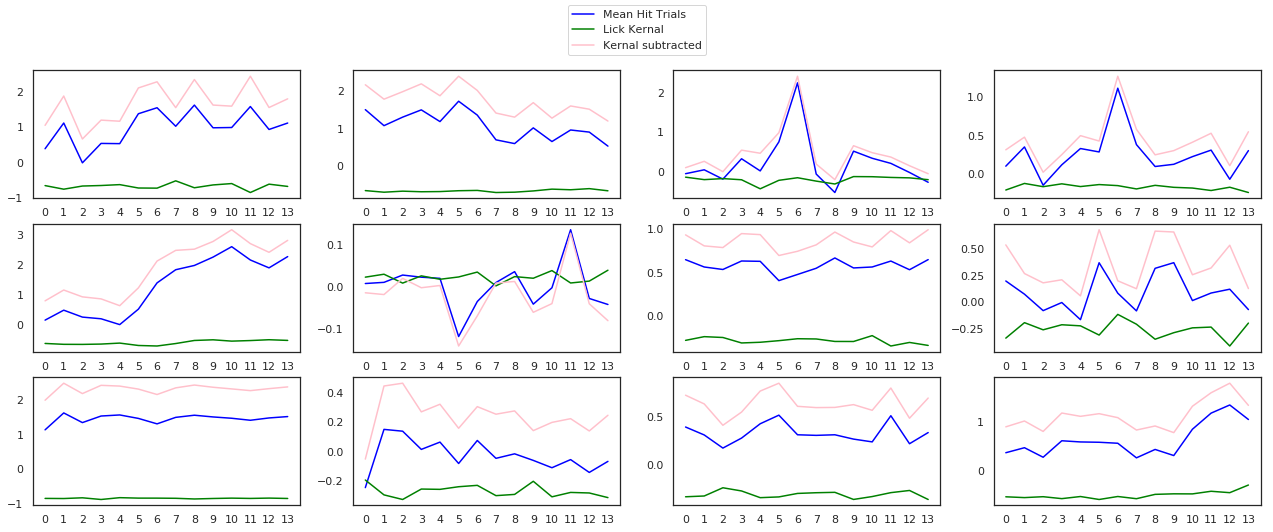

In [31]:
# some examples of subtraction
session_idx = 0
flu_array = copy.deepcopy(behaviour_list[session_idx])
run = copy.deepcopy(runs[session_idx])

intersect = lambda lst1, lst2: list(set(lst1) & set(lst2)) 
hit_trials = copy.deepcopy(hit_list[session_idx])
sub_trials = np.where(Subsets(run).trial_subsets==50)[0]
#sub_trials = hit_trials
trials_to_sub = intersect(hit_trials, sub_trials)
offset_sub = get_time_to_lick(run)

subbed = subtract_kernal(flu_array, run, trials_to_sub, offset_sub, pre_frames=pre_frames,
                         post_frames=post_frames, plot=True)

In [19]:
for stat in runs[session_idx].stat[lickiest]:
    print(stat['original_index'])

3752
261
260
615
7726
1668
7432
7487
4799
7318
7917
8366


In [20]:
run.flu.shape

(2101, 16117)

(0, 2000)

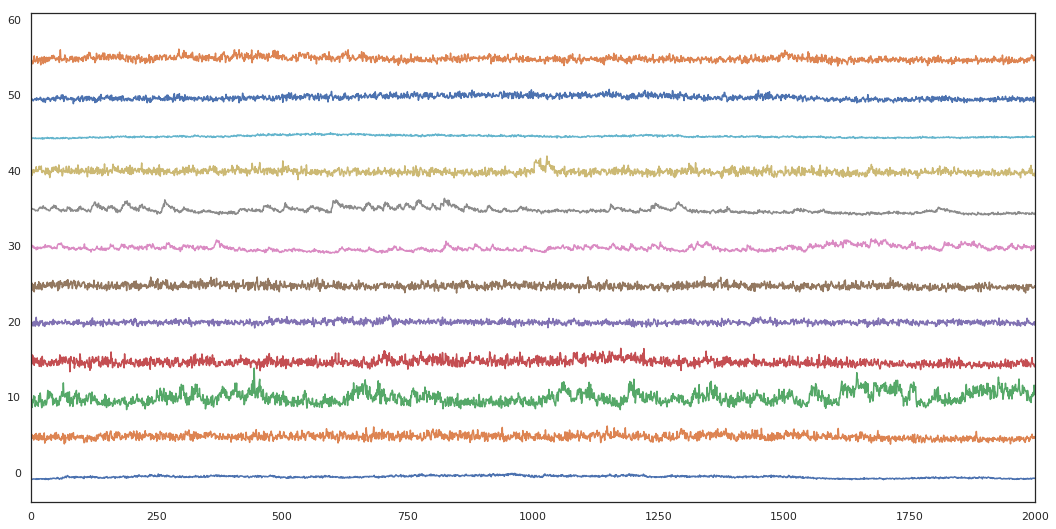

In [21]:
run = runs[session_idx]
plt.figure(figsize=(18,9))
for i, cell in enumerate(lickiest+1):
    
    plt.plot(run.flu[cell, :] + i*5)
plt.xlim((0,2000))


In [22]:
behaviour_list = [subtract_kernal(behaviour_list[session], runs[session], 
                                  hit_list[session], get_time_to_lick(runs[session]),
                                  pre_frames=pre_frames, post_frames=post_frames) 
                  for session in range(n_sessions)]

(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)
(2101, 14)


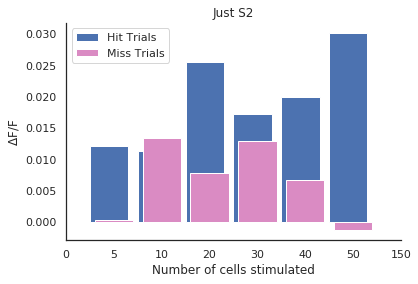

In [23]:
intersect = lambda lst1, lst2: list(set(lst1) & set(lst2)) 

subset_sizes = np.unique(Subsets(runs[0]).trial_subsets)

hit_diffs = []
miss_diffs = []

for i, sub in enumerate(subset_sizes):
    
    if sub == 0 or sub==150:
        continue
        
    hit_trials =  [intersect(np.where((run.outcome=='hit') & (Subsets(run).trial_subsets==sub))[0],
                             good_trials(run))
                             for run in runs]
    
    miss_trials =  [intersect(np.where((run.outcome=='miss') & (Subsets(run).trial_subsets==sub))[0],
                             good_trials(run))
                             for run in runs]

    hit_diff = prepost_diff(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
                            offset=offset, filter_list=hit_trials)
    
    miss_diff = prepost_diff(behaviour_list, pre_frames=pre_frames, post_frames=post_frames, 
                             offset=offset, filter_list=miss_trials)
    
    # hit_diff = hit_diff - lick_diff
       
    if i == 1:
        plt.bar(i-0.1, np.mean(hit_diff), color=sns.color_palette()[0], label='Hit Trials')
        plt.bar(i, np.mean(miss_diff), color=sns.color_palette()[6], label='Miss Trials')
    else:
        plt.bar(i-0.1, np.mean(hit_diff), color=sns.color_palette()[0])
        plt.bar(i, np.mean(miss_diff), color=sns.color_palette()[6])
    
    hit_diffs.append(hit_diff)
    miss_diffs.append(miss_diff)
    
plt.legend()
plt.ylabel(r'$\Delta $F/F')
plt.xlabel('Number of cells stimulated')
sns.despine()
plt.xticks(range(len(subset_sizes)), subset_sizes)
plt.title('Just S2')

hit_diffs = np.array(hit_diffs)
miss_diffs = np.array(miss_diffs)

In [24]:
# which cells contribute most the above plot?
sub = 50

hit_trials =  [intersect(np.where((run.outcome=='hit') & (Subsets(run).trial_subsets==sub))[0],
                         good_trials(run))
                         for run in runs]

_,_,_,cell_averages = averager(behaviour_list, pre_frames=pre_frames, post_frames=post_frames,
                              offset=offset, trial_filter=hit_trials)
    
cell_differ = lambda cell_average: (np.mean(cell_average[:, pre_frames+offset:
                                                           pre_frames+offset+(post_frames-offset)], 1) -
                                    np.mean(cell_average[:, 0:pre_frames], 1))


d = cell_differ(cell_averages[0])
diffest = np.argsort(d)[-12:]
diffest

array([1727, 2075,   38,  971,  149, 1522,  418,  219,  102,  711, 1139,
        996])

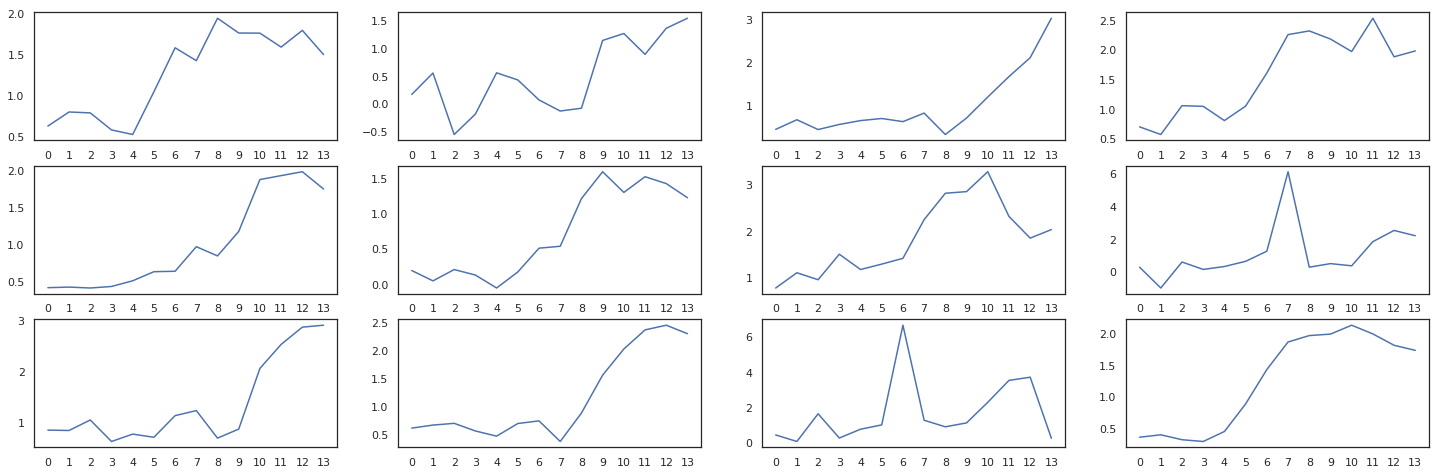

In [25]:
plt.figure(figsize=(25,8))
for i, cell in enumerate(diffest):
    plt.subplot(3,4,i+1)
    plt.plot(cell_averages[0][cell,:])
    plt.xticks(np.arange(pre_frames+post_frames))

In [26]:
cell_averages[0].shape

(2101, 14)

In [27]:
#####    now just using the trial start rather than the onset of a lick bout      #######
# the bin that has at least one lick in it, where there was not a lick previously
# bin_size_ms = 1000
# plt.figure()aa
# lick_hist = plt.hist(licks, bins=range(0,max(licks)+bin_size_ms,bin_size_ms))
# onset_bin_ms = utils.threshold_detect(lick_hist[0], 0.5) * bin_size_ms
# # the time of the first lick each onset bin 
# first_lick_bin = [min(licks, key=lambda x:abs(x-ms)) for ms in onset_bin_ms]